In [26]:
# Import Python libaries
%matplotlib inline
from scipy.optimize import curve_fit
import time as time
# general data management
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn import ensemble
from xgboost import plot_tree
from sklearn.tree import DecisionTreeRegressor
# import pydo
# generate random integer genues
from random import seed
from random import randint
# seed random number generator
seed(1)
# Machine learning & model visualization tools
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error, mean_gamma_deviance, mean_absolute_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import cov
from scipy.stats import pearsonr
from scipy import ndimage, misc

from scipy import stats 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
# Miscellaneous
import os
import io
import pydot
import math
from sklearn.inspection import partial_dependence, plot_partial_dependence

import matplotlib as mpl

import pickle
from sklearn.metrics import explained_variance_score
from tensorflow.keras.models     import Model, load_model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import SpectralEmbedding
from matplotlib import rc, rcParams



In [27]:
plt.rcParams["font.family"] = "Arial"

plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42

mpl.font_manager.FontManager()


# make the numbers on axis bold
rc('font', weight='bold')

In [28]:
encoder = load_model('./../data/nns_9HA_noemb_6b6/keep/encoder_newencinp.h5')
decoder = load_model('./../data/nns_9HA_noemb_6b6/keep/decoder_newencinp.h5')
regressor =     load_model('./../data/nns_9HA_noemb_6b6/keep/regressor.h5')
regressor_top = load_model('./../data/nns_9HA_noemb_6b6/keep/regressor_top.h5')
generator = load_model    ('./../data/nns_9HA_noemb_6b6/keep/generator_new.h5')
discriminator= load_model ('./../data/nns_9HA_noemb_6b6/keep/discriminator_new.h5')

In [29]:
# read the generated data
csv_name = './../experiments/regular_9HA_6b6latent/latent/Regular_noscreenrelug.csv'
gen_SMILES = pd.read_csv(csv_name)
gen_smiles = gen_SMILES ['SMILES']
sample_ys = gen_SMILES ['des_cv']
gen_cv = gen_SMILES ['pred_cv']
gen_error = gen_SMILES ['Err_pred_des']

In [30]:
with open('./../experiments/regular_9HA_6b6latent/latent/gen_atoms_bonds.pickle', 'rb') as f:
    gen_atoms_embedding, gen_bonds_embedding = pickle.load(f)

"""
with open('./../data/trainingsets/60000_train_regular_qm9/image_train.pickle', 'rb') as f:
    X_smiles_train, SMILES_train, X_atoms_train, X_bonds_train, y_train0 = pickle.load(f)
"""
 
with open('./../data/trainingsets/60000_train_regular_qm9/train_GAN.pickle', 'rb') as f:
    X_smiles_train, SMILES_train, y_train0 = pickle.load(f)


print ('gen_cv', gen_cv)
print ('des cv', sample_ys)

idx = np.random.choice(len(y_train0), int(len(y_train0) * 0.016), replace=False)
cv_train = y_train0[idx]
train_cv = cv_train
X_smiles_train = X_smiles_train[idx]
SMILES_train = SMILES_train[idx]

gen_cv 0       34.996326
1       32.397680
2       33.822070
3       35.028630
4       28.103127
          ...    
1200    22.512419
1201    31.435417
1202    33.280785
1203    35.538773
1204    38.131073
Name: pred_cv, Length: 1205, dtype: float64
des cv 0       35.0185
1       35.0185
2       31.9303
3       31.9303
4       31.9303
         ...   
1200    23.4195
1201    23.4195
1202    23.4195
1203    35.8230
1204    35.8230
Name: des_cv, Length: 1205, dtype: float64


In [31]:
X_smiles_train_ = []
for i in X_smiles_train:
  X_smiles_train_.append(i)
X_smiles_train = np.array (X_smiles_train_)
print (X_smiles_train.shape)

cv_train_ = []
for i in cv_train:
  cv_train_.append(i)
cv_train = np.array (cv_train_)
print (cv_train.shape)

SMILES_train_ = []
for smiles in SMILES_train:
  SMILES_train_.append(smiles)
SMILES_train = np.array (SMILES_train_)
print (SMILES_train.shape)

(1355, 35, 23, 1)
(1355,)
(1355,)


In [32]:
Qs_gen = np.quantile(gen_cv, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
Qs = np.quantile(train_cv, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
#Qs_gen = Qs
#Qs = Qs_gen
y_class_gen = gen_cv.copy()
y_class = train_cv.copy()
print ("quantile of train samples: ", Qs)

# 4 classes: same # samples
y_class_gen = np.where(gen_cv <= (Qs_gen[1]+Qs_gen[2])/2, 0, y_class_gen)
y_class_gen = np.where((gen_cv > (Qs_gen[1]+Qs_gen[2])/2) & (gen_cv <= Qs_gen[4]), 1, y_class_gen)
y_class_gen = np.where((gen_cv > Qs_gen[4]) & (gen_cv <= (Qs_gen[6]+Qs_gen[7])/2), 2, y_class_gen)
y_class_gen = np.where(gen_cv > (Qs_gen[6]+Qs_gen[7])/2, 3, y_class_gen)

# 4 classes
y_class = np.where(train_cv <= (Qs[1]+Qs[2])/2, 0, y_class)
y_class = np.where((train_cv > (Qs[1]+Qs[2])/2) & (train_cv <= Qs[4]), 1, y_class)
y_class = np.where((train_cv > Qs[4]) & (train_cv <= (Qs[6]+Qs[7])/2), 2, y_class)
y_class = np.where(train_cv > (Qs[6]+Qs[7])/2, 3, y_class)

print ('gen class==0', sum(y_class_gen==0))
print ('gen class==1', sum(y_class_gen==1))
print ('gen class==2', sum(y_class_gen==2))
print ('gen class==3', sum(y_class_gen==3))

print ('train class==0', sum(y_class==0))
print ('train class==1', sum(y_class==1))
print ('train class==2', sum(y_class==2))
print ('train class==3', sum(y_class==3))

group_names = np.array([r"C$_\nu$≤{}".format(np.round((Qs[1]+Qs[2])/2)), 
                            r"{}<C$_\nu$≤{}".format(np.round((Qs[1]+Qs[2])/2), np.round(Qs[4])),
                            r"{}<C$_\nu$≤{}".format(np.round(Qs[4]), np.round((Qs[6]+Qs[7])/2)),
                            r"{}<C$_\nu$".format(np.round((Qs[6]+Qs[7])/2))])
#group_names_gen = group_names
group_names_gen = np.array([r"C$_\nu$≤{}".format(np.round((Qs_gen[1]+Qs_gen[2])/2)),
                            r"{}<C$_\nu$≤{}".format(np.round((Qs_gen[1]+Qs_gen[2])/2), np.round(Qs_gen[4])),
                            r"{}<C$_\nu$≤{}".format(np.round(Qs_gen[4]), np.round((Qs_gen[6]+Qs_gen[7])/2)),
                            r"{}<C$_\nu$".format(np.round((Qs_gen[6]+Qs_gen[7])/2))])

quantile of train samples:  [22.937399673461915 25.19080009460449 27.338399505615236
 29.347000122070312 31.600000381469727 33.674800109863284 35.8
 37.652000427246094 40.07379913330079]
gen class==0 295
gen class==1 308
gen class==2 303
gen class==3 299
train class==0 337
train class==1 341
train class==2 328
train class==3 349


explained_varice_R2_DFT_des 0.44133037774479855
0.42110888803748303


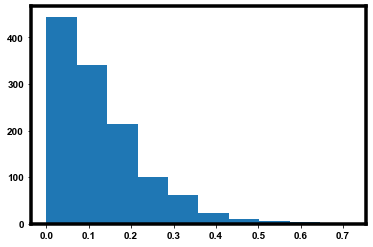

In [33]:
plt.close()
plt.hist(gen_error)
plt.savefig("gen_error_hist.png")

# total # of samples
N = len(gen_error)
# Explained Variance R2 from sklearn.metrics.explained_variance_score
explained_variance_R2_DFT_des = explained_variance_score(sample_ys, gen_cv)
print ("explained_varice_R2_DFT_des", explained_variance_R2_DFT_des)
rsquared = r2_score (sample_ys, gen_cv)
print (rsquared)

gen_atoms_embedding = np.array(gen_atoms_embedding)
gen_bonds_embedding = np.array(gen_bonds_embedding)

# create classes for heat capacity
# using cv_train, uniformly distributed.
s_max_norm = 42.302
s_min_norm = 21.02

In [34]:
# ANALYSIS
train_atoms_embedding, train_bonds_embedding, _ = encoder.predict([X_smiles_train]) 


43/43 [==============================] - 2s 45ms/step


In [35]:
X_atoms_train_ = train_atoms_embedding.reshape([train_atoms_embedding.shape[0], 6*6])
X_bonds_train_ = train_bonds_embedding.reshape([train_bonds_embedding.shape[0], 6*6])

X_atoms_test_ = gen_atoms_embedding.reshape([gen_atoms_embedding.shape[0], 6*6])
X_bonds_test_ = gen_bonds_embedding.reshape([gen_bonds_embedding.shape[0], 6*6])

In [36]:
colors = ['darkblue', 'lightsteelblue', 'orangered', 'darkred']

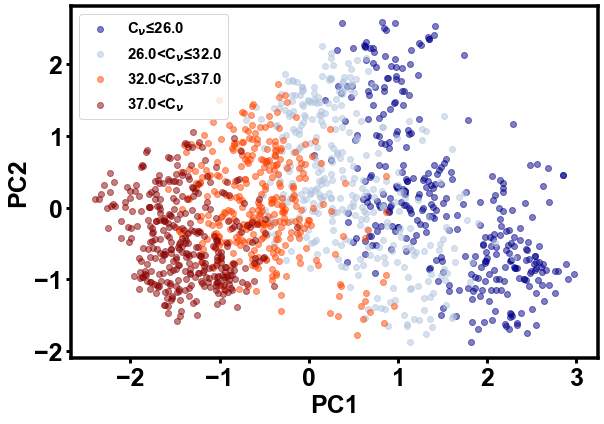

In [37]:
# PCA analysis
target_ids = range(0, 4)
# pc1 vs. pc2 concat 
X_Concat_train =  np.concatenate ([X_bonds_train_, X_atoms_train_], axis=1)
X_Concat_test  =  np.concatenate ([X_bonds_test_, X_atoms_test_], axis=1)
pca_2 = PCA(n_components = 3)
X_concat_train_pca = pca_2.fit_transform(X_Concat_train)
X_concat_test_pca = pca_2.transform(X_Concat_test)


plt.close()
fig, ax = plt.subplots(figsize =(8.5, 6))
ax.tick_params(axis='both', which='major', labelsize=25)
mpl.rcParams['axes.linewidth'] = 3.5
for i, c, label in zip(target_ids, colors, group_names_gen):
            plt.scatter(X_concat_test_pca[y_class_gen == i, 0],
                        X_concat_test_pca[y_class_gen == i, 1],
                        alpha=0.5, c=c, label=label)
plt.legend(fontsize=15)
ax.tick_params(width=3, length=5)

plt.xlabel('PC1', fontsize=25, fontweight='bold', fontname='Arial')
plt.ylabel('PC2', fontsize=25, fontweight='bold', fontname='Arial')
plt.savefig("test_conc_dist_pca.png", bbox_inches='tight', dpi=300)

plt.close()
fig, ax = plt.subplots(figsize =(8.5, 6))
ax.tick_params(axis='both', which='major', labelsize=25)
mpl.rcParams['axes.linewidth'] = 3.5
for i, c, label in zip(target_ids, colors, group_names):
            plt.scatter(X_concat_train_pca[y_class == i, 0],
                        X_concat_train_pca[y_class == i, 1],
                        alpha=0.5, c=c, label=label)
plt.legend(fontsize=15)
ax.tick_params(width=3, length=5)
plt.xlabel('PC1', fontsize=25, fontweight='bold', fontname='Arial')
plt.ylabel('PC2', fontsize=25, fontweight='bold', fontname='Arial')
plt.tight_layout()
plt.savefig("train_conc_dist_pca.png", bbox_inches='tight', dpi=300)


perplexities = [20, 30, 40, 45, 50, 60, 100, 120]
perplexities = [40, 45, 50]
seed = 100
n_iter = 10000

### concat. latent vectors ###
X_Concat_train =  np.concatenate ([X_bonds_train_, X_atoms_train_], axis=1)
X_Concat_test  =  np.concatenate ([X_bonds_test_, X_atoms_test_], axis=1)
pca_2 = PCA(n_components=3)
X_concat_train_pca = pca_2.fit_transform(X_Concat_train)
X_concat_test_pca = pca_2.transform(X_Concat_test)

In [38]:
# t-SNE analysis
### tsne of combined atom and bond matrices ###
X_Concat_train_tsne = TSNE(verbose=1, learning_rate=10, n_iter=n_iter, min_grad_norm=1e-50,
                          n_components=2, perplexity=48, random_state=20, angle=0.5, 
                          n_jobs=-1, square_distances=True, init='pca'
                         ).fit_transform(X_concat_train_pca)

X_Concat_test_tsne = TSNE(verbose=1, learning_rate=10, n_iter=n_iter, min_grad_norm=1e-50,
                          n_components=2, perplexity=50, random_state=20, angle=0.5, 
                          n_jobs=-1, square_distances=True, init='pca'
                         ).fit_transform(X_concat_test_pca)
	
###
"""
# using .pickle to save mapped vectors	
with open('./TSNE_variables.pickle', 'wb') as f:
		pickle.dump((X_Concat_train_tsne, X_Concat_test_tsne), f)
	
with open('./TSNE_variables.pickle', 'rb') as f:
		X_Concat_train_tsne, X_Concat_test_tsne = pickle.load(f)
"""

# using .csv file to save mapped vectors
tsne_components = pd.DataFrame()
tsne_components['SMILES'] = SMILES_train
tsne_components['cv'] = train_cv
tsne_components['class'] = y_class
tsne_components['train_tsne1'] = np.array (X_Concat_train_tsne)[:, 0]
tsne_components['train_tsne2'] = np.array (X_Concat_train_tsne)[:, 1]
train_tsne1 = (np.array (X_Concat_train_tsne)[:, 0]).reshape(-1, 1)
train_tsne2 = (np.array (X_Concat_train_tsne)[:, 1]).reshape(-1, 1)
tsne_components.to_csv('./TSNE_variables_train1.csv')
tsne_components = pd.DataFrame()
tsne_components['SMILES'] = gen_smiles
tsne_components['pred_cv'] = gen_cv
tsne_components['class'] = y_class_gen
tsne_components['test_tsne1'] = np.array (X_Concat_test_tsne)[:, 0]
tsne_components['test_tsne2'] = np.array (X_Concat_test_tsne)[:, 1]
gen_tsne1 = (np.array (X_Concat_test_tsne)[:, 0]).reshape(-1, 1)
gen_tsne2 = (np.array (X_Concat_test_tsne)[:, 1]).reshape(-1, 1)
tsne_components.to_csv('./TSNE_variables_test1.csv')

[t-SNE] Computing 145 nearest neighbors...
[t-SNE] Indexed 1355 samples in 0.001s...
[t-SNE] Computed neighbors for 1355 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1355
[t-SNE] Computed conditional probabilities for sample 1355 / 1355
[t-SNE] Mean sigma: 0.349735


C:\Users\Fatemeh\Anaconda3\envs\rdkit_env\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.401737
[t-SNE] KL divergence after 6800 iterations: 0.629400
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1205 samples in 0.001s...
[t-SNE] Computed neighbors for 1205 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1205
[t-SNE] Computed conditional probabilities for sample 1205 / 1205
[t-SNE] Mean sigma: 0.283393


C:\Users\Fatemeh\Anaconda3\envs\rdkit_env\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.232452
[t-SNE] KL divergence after 6500 iterations: 0.600349


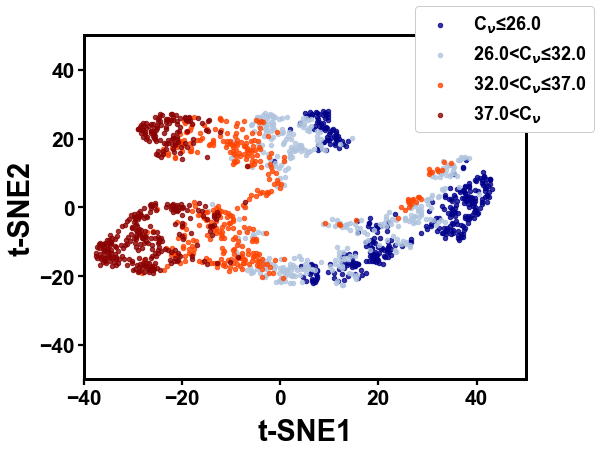

In [39]:
# qm9 data
plt.close()
mpl.rcParams['axes.linewidth'] = 3
fig, ax = plt.subplots(figsize =(7.5, 6))
ax.set_xlabel('t-SNE1', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('t-SNE1', fontsize='18', fontname='Arial', fontweight='bold')
ax.tick_params(length=6, width=2.25, colors='black', grid_alpha=0, labelsize='21')

target_ids = range(0, 4)

colors = ['darkblue', 'lightsteelblue', 'orangered', 'darkred']
X_Concat_train_tsne = np.concatenate ([train_tsne1, train_tsne2], axis=1)

ax.set_xlabel('t-SNE1', fontsize='29', fontname='Arial', fontweight='bold', labelpad=10)
ax.set_ylabel('t-SNE2', fontsize='29', fontname='Arial', fontweight='bold')


for i, c, label in zip(target_ids, colors, group_names):
    plt.scatter(X_Concat_train_tsne[y_class == i, 0], 
    X_Concat_train_tsne[y_class == i, 1], 
    alpha=0.8, c=c, label=label, s=20)
plt.xlim(-40, 50)
plt.ylim(-50, 50)
plt.tight_layout()
ax.legend(frameon=True, ncol=1, fontsize=18, loc=(0.75, 0.72), framealpha=1)
plt.savefig("tsne_train.png", bbox_inches='tight', dpi=300)

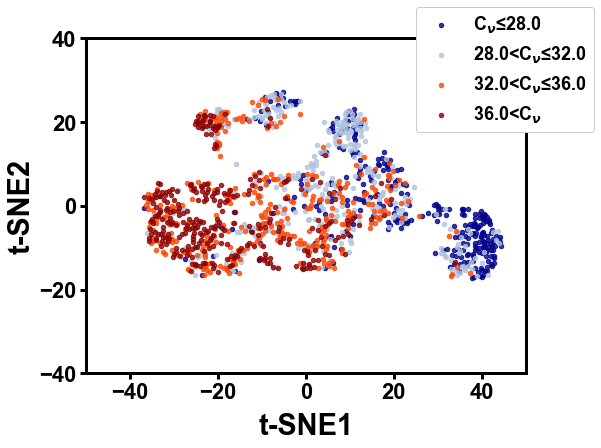

In [40]:
# qm9 data
plt.close()
mpl.rcParams['axes.linewidth'] = 3
fig, ax = plt.subplots(figsize =(7.5, 6))

ax.set_xlabel('t-SNE1', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_ylabel('t-SNE1', fontsize='20', fontname='Arial', fontweight='bold')
ax.tick_params(length=6, width=3, colors='black', grid_alpha=0, labelsize='22')


target_ids = range(0, 4)

colors = ['darkblue', 'lightsteelblue', 'orangered', 'darkred']
X_Concat_gen_tsne = np.concatenate ([gen_tsne1, gen_tsne2], axis=1)

ax.set_xlabel('t-SNE1', fontsize='29', fontname='Arial', fontweight='bold', labelpad=10)
ax.set_ylabel('t-SNE2', fontsize='29', fontname='Arial', fontweight='bold')


for i, c, label in zip(target_ids, colors, group_names_gen):
    plt.scatter(X_Concat_gen_tsne[y_class_gen == i, 0], 
    X_Concat_gen_tsne[y_class_gen == i, 1], 
    alpha=0.8, c=c, label=label, s=20)
plt.xlim(-50, 50)
plt.ylim(-40, 40)
plt.yticks(np.arange(-40, 41, 20))
plt.tight_layout()
ax.legend(frameon=True, ncol=1, fontsize=18, loc=(0.75, 0.72), framealpha=1)
plt.savefig("tsne_gen.png", bbox_inches='tight', dpi=300)

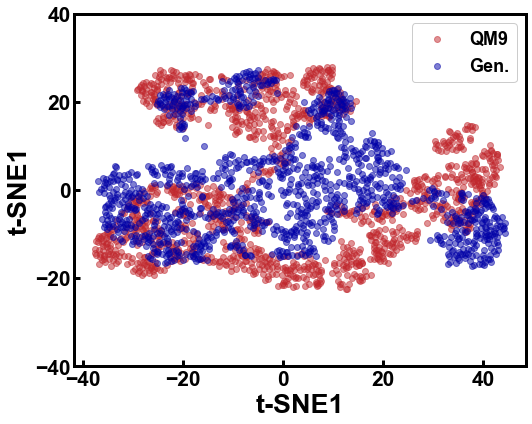

In [41]:
plt.close()
mpl.rcParams['axes.linewidth'] = 3
fig, ax = plt.subplots(figsize =(7.5, 6))

ax.set_xlabel('t-SNE1', fontsize='27', fontname='Arial', fontweight='bold')
ax.set_ylabel('t-SNE1', fontsize='27', fontname='Arial', fontweight='bold')
ax.tick_params(direction='in', length=6, width=3, colors='black', grid_alpha=0, labelsize='21')

plt.scatter (train_tsne1, train_tsne2, color='#c1272d', alpha=0.5, label='QM9')
plt.scatter (gen_tsne1, gen_tsne2, color='#0000a7', alpha=0.5, label='Gen.')

plt.tight_layout()
plt.yticks(np.arange(-40, 41, 20))
ax.legend(frameon=True, ncol=1, fontsize=18, framealpha=1)
plt.tight_layout()
plt.savefig("tsne_genvstrain.png", bbox_inches='tight', dpi=300)

In [ ]:
plt.close()
fig, ax = plt.subplots(figsize =(8.5, 6))
ax.tick_params(axis='both', which='major', labelsize=25)
mpl.rcParams['axes.linewidth'] = 3.5
for i, c, label in zip(target_ids, colors, group_names):
            plt.scatter(X_concat_train_pca[y_class == i, 0],
                        X_concat_train_pca[y_class == i, 1],
                        alpha=0.5, c=c, label=label)
plt.legend(fontsize=15)
ax.tick_params(width=3, length=5)
plt.xlabel('PC1', fontsize=25, fontweight='bold', fontname='Arial')
plt.ylabel('PC2', fontsize=25, fontweight='bold', fontname='Arial')
plt.tight_layout()
plt.savefig("train_conc_dist_pca.png", bbox_inches='tight', dpi=300)

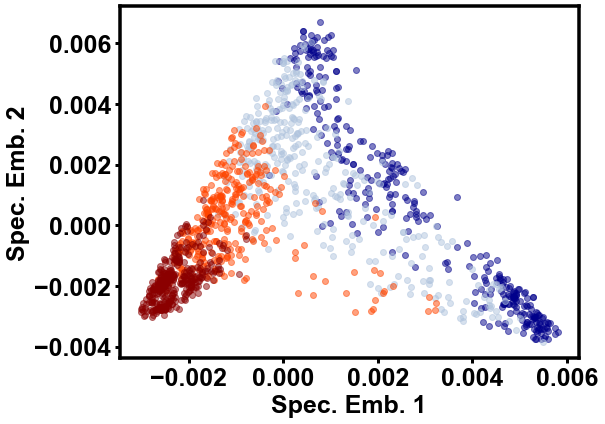

In [49]:
# SpectralEmbedding dimension reduction
embedding = SpectralEmbedding(n_components=2, n_jobs=-1)
X_concat_train_SpectralEmbedding = embedding.fit_transform(X_Concat_train)
X_concat_test_SpectralEmbedding = embedding.fit_transform(X_Concat_test)

plt.close()
fig, ax = plt.subplots(figsize =(8.5, 6))
ax.tick_params(axis='both', which='major', labelsize=25)
mpl.rcParams['axes.linewidth'] = 3.5
for i, c, label in zip(target_ids, colors, group_names):
            plt.scatter(X_concat_test_SpectralEmbedding[y_class_gen == i, 0],
                        X_concat_test_SpectralEmbedding[y_class_gen == i, 1],
                        alpha=0.5, c=c, label=label)
#plt.legend(fontsize=12)
ax.tick_params(width=3, length=5)
plt.xlabel('Spec. Emb. 1', fontsize=25, fontweight='bold')
plt.ylabel('Spec. Emb. 2', fontsize=25, fontweight='bold')
plt.tight_layout()
plt.savefig("test_conc_dist_SpectralEmbedding.jpeg", bbox_inches='tight', dpi=500)


plt.close()
fig, ax = plt.subplots(figsize =(8.5, 6))
ax.tick_params(axis='both', which='major', labelsize=25)
mpl.rcParams['axes.linewidth'] = 3.5
for i, c, label in zip(target_ids, colors, group_names):
            plt.scatter(X_concat_train_SpectralEmbedding[y_class == i, 0],
                        X_concat_train_SpectralEmbedding[y_class == i, 1],
                        alpha=0.5, c=c, label=label)
#plt.legend(fontsize=12)
ax.tick_params(width=3, length=5)
plt.xlabel('Spec. Emb. 1', fontsize=25, fontweight='bold', fontname='Arial')
plt.ylabel('Spec. Emb. 2', fontsize=25, fontweight='bold', fontname='Arial')
plt.tight_layout()
plt.savefig("train_conc_dist_SpectralEmbedding.jpeg", bbox_inches='tight', dpi=500)
